# Import Dataset for First Check

In [2]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
from scipy.stats import norm, skew
import seaborn as sns
import warnings
import matplotlib.gridspec as gridspec
import matplotlib as mpl
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler 
warnings.filterwarnings("ignore")
%matplotlib inline

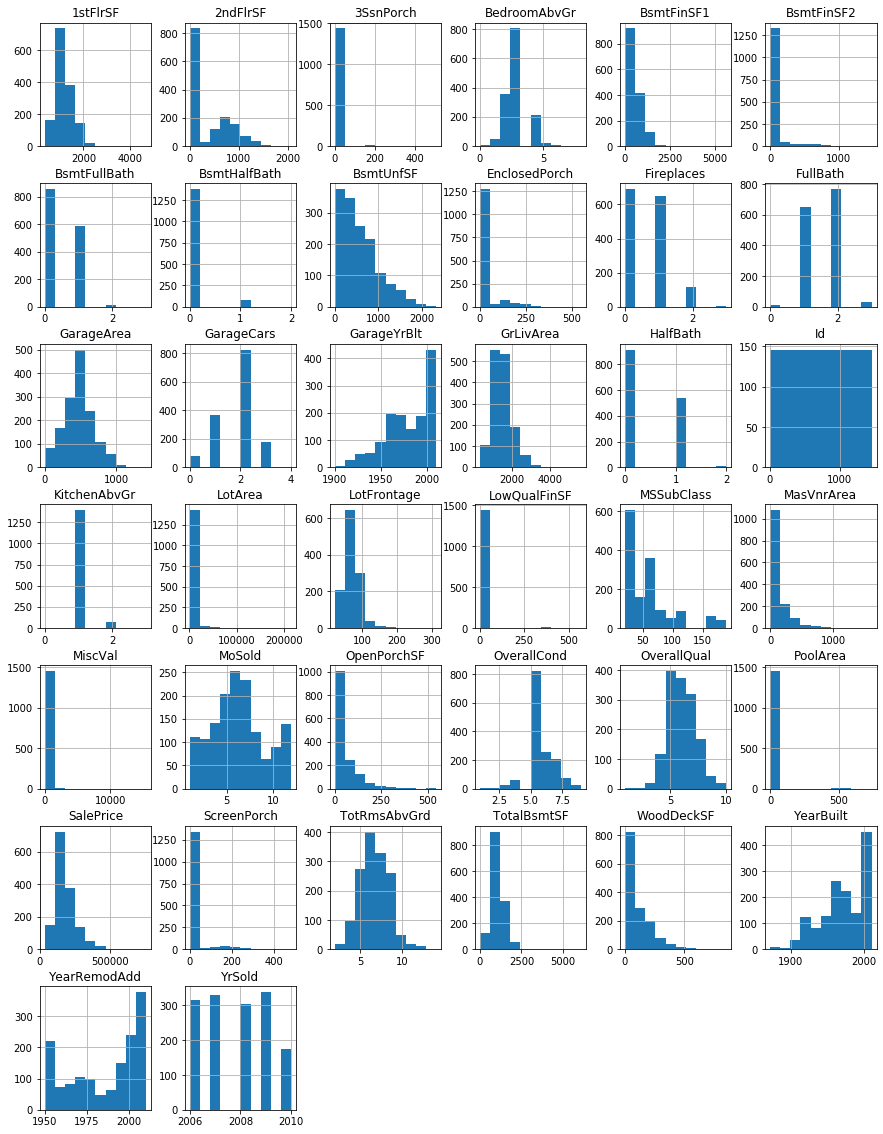

In [4]:
h_price = pd.read_csv('./original_dataset/train.csv')
h_price_test = pd.read_csv('./original_dataset/test.csv')
h_price.hist(figsize=(15,20))
plt.show()

# Target Feature Transformation

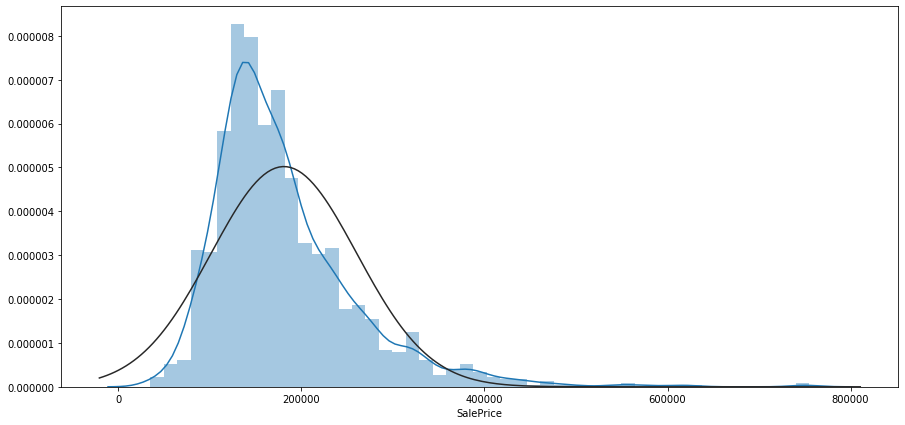

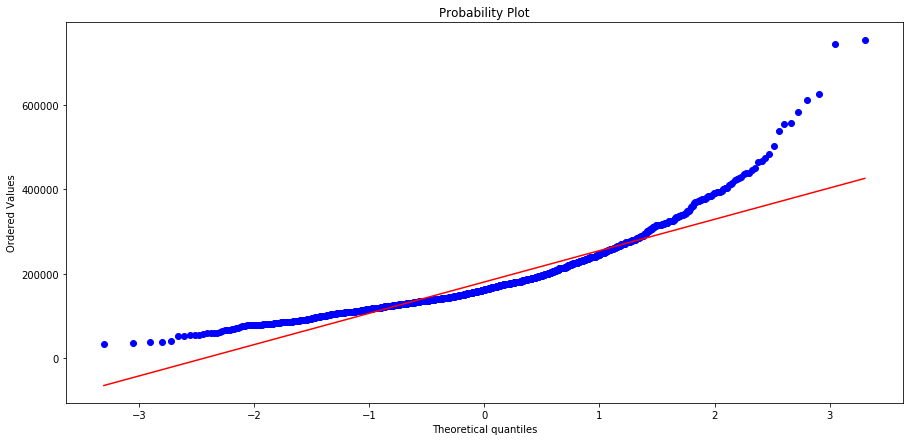

In [338]:
# normalirity check
# check the histgram and probplot to see whether the target feature is normal distributed
sns.distplot(h_price['SalePrice'], fit=norm)
fig = plt.figure()
pro = stats.probplot(h_price['SalePrice'], plot=plt)

Now the histplot and proplot look much better!


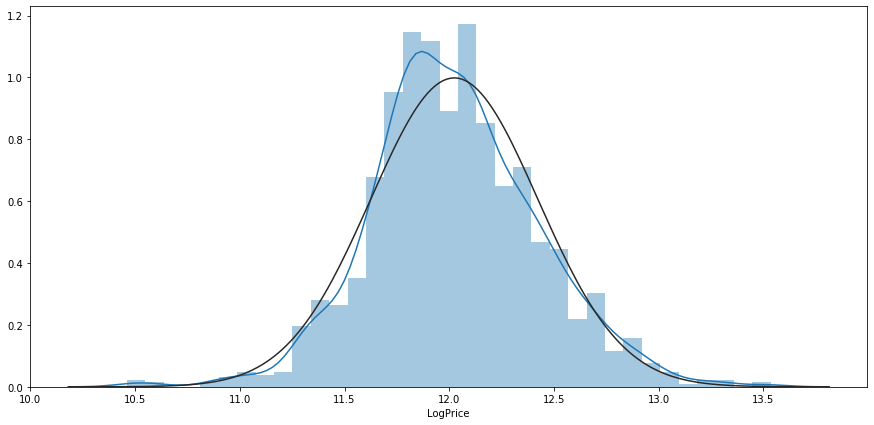

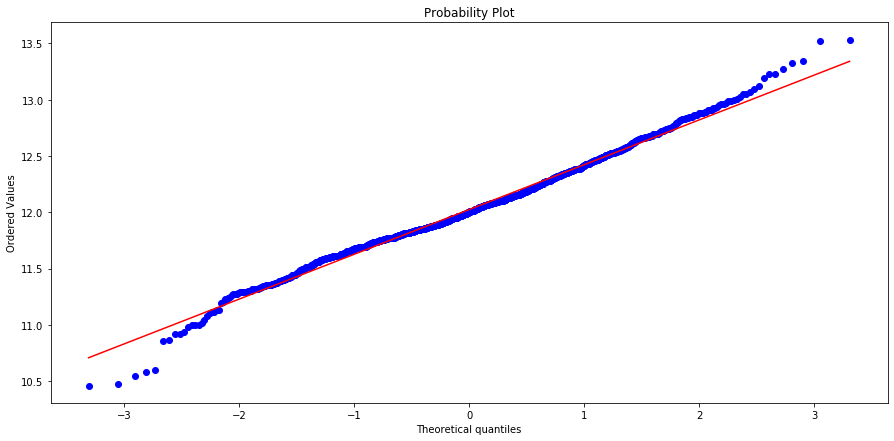

In [350]:
# feature transformation
# since the probplot look like log distribution, we can transform it by np.log()
h_price['LogPrice'] = np.log(h_price['SalePrice'])
print("Now the histplot and proplot look much better!")
dist_price = sns.distplot(h_price['LogPrice'], fit=norm)
fig = plt.figure()
pro_log = stats.probplot(h_price['LogPrice'], plot=plt)
plt.show()

# Correation Check and Remove the Outliers

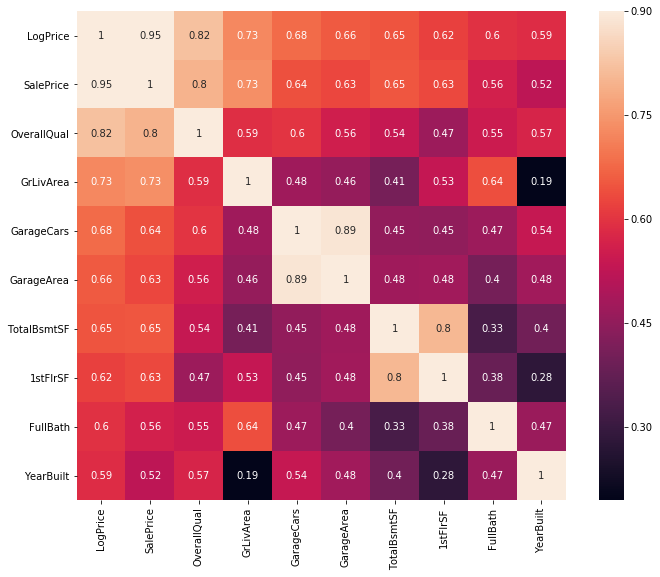

In [351]:
#correlation check for each feature with target feature and plot the first ten high corr features
conti_corre = h_price.corr()
plt.subplots(figsize=(12,9))
cols = conti_corre.nlargest(10, 'LogPrice')['LogPrice'].index
cm = np.corrcoef(h_price[cols].values.T)
sns.heatmap(cm, vmax=0.9,annot=True, square=True,annot_kws={'size': 10},
           yticklabels=cols.values, xticklabels=cols.values)

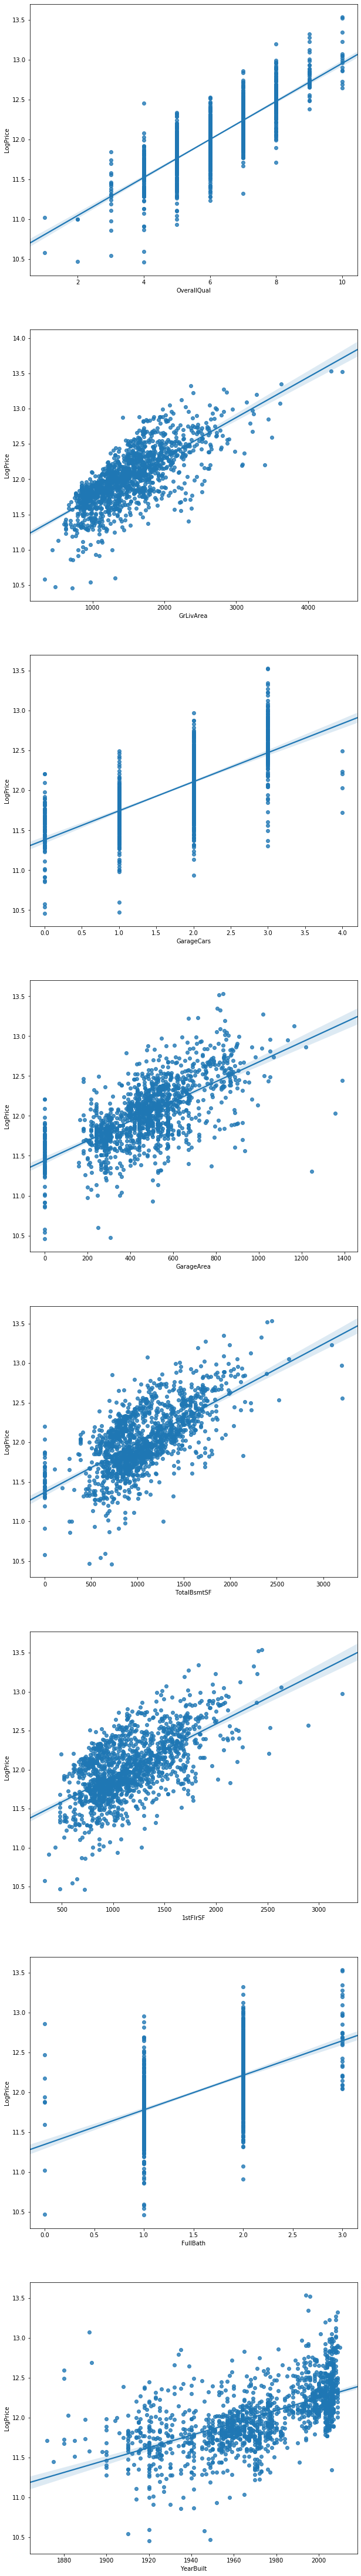

In [352]:
#Removing outliers based on highly correlated features:
major_feature = list(cols)[2:10]
gs2 = gridspec.GridSpec(len(major_feature), 1)
fig = plt.figure(figsize=(10, 80))
j = 0
for feature in major_feature:
    ax1 = plt.subplot(gs2[j, 0])
    sns.regplot(h_price[feature], h_price['LogPrice'], ax= ax1)
    j += 1
#based on the regplot, we can drop two outliers, and then test the corr of all features with price, 
#correlations are increased after removing these two outliers
h_price = h_price.drop(h_price[(h_price['GrLivArea']>4000) & (h_price['SalePrice']<300000)].index)
r_train = h_price.shape[0]

# Missingness imputation

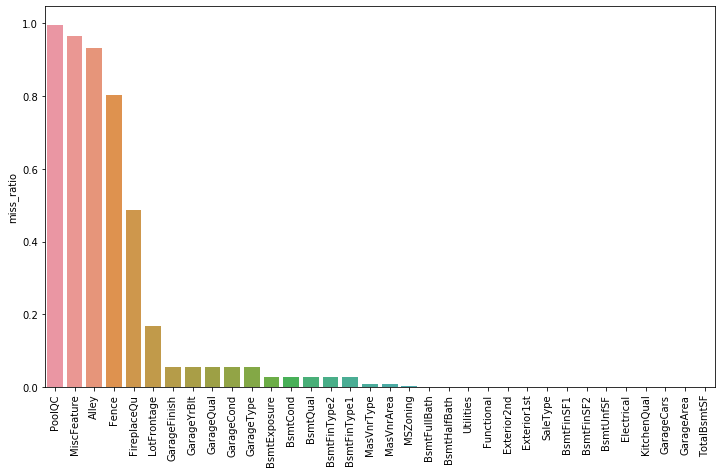

In [375]:
# check the missness ratio
plt.figure(figsize= (12,7))
plt.xticks(rotation='90')
# we combine the train dataset and test dataset together to hadling missness
attri = pd.concat([h_price.iloc[:,1:80], h_price_test.iloc[:,1:]], axis= 0, join = 'outer', ignore_index=True)
col_na = attri.loc[:,attri.isna().any()]
mis_ratio = pd.DataFrame((col_na.isna().sum()/col_na.shape[0]).sort_values(ascending = False),
                        columns = ['miss_ratio'])
sns.barplot(mis_ratio.index, mis_ratio.miss_ratio)


In [376]:
# Impute missing value
# We firstly look through the feature describtion and catarized our data as three types

# for these columns, the NAN are missing value, we groupby neighbourhoods and then fill with high frequence value
Type_col = ['Exterior1st', 'Exterior2nd', 'MSZoning','Functional','SaleType','Electrical','GarageYrBlt']
for name in Type_col:
    attri[name] = attri.groupby(['Neighborhood'])[name].transform(lambda x: x.fillna(x.mode()[0]))
    
# the NAN values in these columns represent the 'None' catagory, we replace NAN with 'None' 
None_col = ['Alley', 'MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure','BsmtFinType1',
           'BsmtFinType2','FireplaceQu', 'GarageFinish','GarageQual',
           'GarageType', 'GarageCond', 'PoolQC', 'Fence','MiscFeature','KitchenQual']
for name in None_col:
    attri[name] = attri[name].fillna('None')

# for these columns, NAN means 0
Zero_col = ['MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','BsmtFullBath',
           'BsmtHalfBath','GarageCars','GarageArea']
for name in Zero_col:
    attri[name] = attri[name].fillna(0)

attri['LotFrontage'] = attri.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))


# Feature Engineering

In [377]:
# add one feature which represents the total square feet of the house
attri['TotalSF'] = attri['TotalBsmtSF'] + attri['1stFlrSF'] + attri['2ndFlrSF']

# drop the useless features: ID, Utilities, Yrsold and LowQualFinSF
#attri.drop(['Utilities','YrSold','LowQualFinSF'], axis = 1, inplace = True)

# classify the catagorical features and continurous features
conti = ['LotFrontage', 'LotArea', 'MasVnrArea','BsmtFinSF1',
         'BsmtFinSF2','BsmtUnfSF','TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
         'GrLivArea','Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF', 
         'OpenPorchSF', 'EnclosedPorch','3SsnPorch', 'ScreenPorch', 'MiscVal','MoSold',
         'YearRemodAdd','TotalSF','BedroomAbvGr','TotRmsAbvGrd','YearBuilt','GarageYrBlt']

# quantical catagorical data
quant = ['Street','CentralAir','Alley','PoolArea', 'LandContour','LotShape',
         'LandSlope','BldgType', 'MasVnrType','SaleType', 'MiscFeature','Fence', 
         'Electrical', 'SaleCondition']

#ordi means the catagorical data which can be impute by numbers and treat as numerical data
ordi = ['OverallQual','OverallCond','ExterCond','ExterQual','BsmtQual',
        'BsmtCond', 'BsmtExposure','HeatingQC','KitchenQual','FireplaceQu',
        'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive',
        'BsmtFinType1','BsmtFinType2']

# nominal catagorical data
nomi = ['MSSubClass', 'MSZoning','LotConfig', 'Neighborhood','Condition1',
        'Condition2', 'BldgType','HouseStyle', 'RoofStyle', 'RoofMatl',
        'Exterior1st', 'Exterior2nd','Foundation','Heating','Functional',
        'PoolQC','GarageType','BsmtFullBath','BsmtHalfBath', 'FullBath',
        'HalfBath', 'KitchenAbvGr','Electrical']

for name in conti:
    attri[name] = attri[name].astype('float64')
    
for name in ordi:
    attri.loc[attri[name] == 'GLQ', name] = 12
    attri.loc[attri[name].isin(['Ex','ALQ']), name] = 10
    attri.loc[attri[name].isin(['Gd','GdPrv','BLQ']), name] = 8
    attri.loc[attri[name].isin(['TA','Av','MnPrv','Fin','Rec','Y']), name] = 6
    attri.loc[attri[name].isin(['Fa','Mn','GdWo','RFn','LwQ','P']), name] = 4
    attri.loc[attri[name].isin(['Po','No','MnWw','Unf','N']), name] = 2
    attri.loc[attri[name] == 'None', name] = 0

conti_feature = conti + ordi

#catagorical data cleaning before dummifying
RoofM_other = ['Membran','ClyTile', 'Metal', 'Roll', 'WdShngl','WdShake']
attri.loc[attri['RoofMatl'].isin(RoofM_other),'RoofMatl'] = 'others'
attri.loc[attri['PoolQC'].isin(['Ex','Gd', 'Fa']),'PoolQC'] = 'Have_Pool'
attri.loc[attri['PoolArea']>0,'PoolArea'] = 1
attri.loc[attri['Condition2'].isin(['RRAn','RRAe']),'Condition2'] = 'Norm'
attri.loc[attri['Condition2'].isin(['RRNn','Artery','Feedr']),'Condition2'] = 'Other'
attri.loc[attri['Condition2'].isin(['PosA','PosN']),'Condition2'] = 'Pos'
attri.loc[attri['Heating'].isin(['Wall','OthW','Floor']),'Heating'] = 'other'
attri.loc[attri['MiscFeature'].isin(['TenC','Othr','Gar2']),'MiscFeature'] = 'other'
# dummify catagorical features
attri = pd.get_dummies(attri)

In [378]:
#check the attri shape and chaek out the NA values
print(attri.shape)
attri.loc[:,attri.isna().any()].head()


(2917, 229)


""
0
1
2
3
4


# Find Skew Feature and use Boxcox to transform features

In [456]:
skewness = attri[conti_feature].apply(lambda x: skew(x)).sort_values()
Skew = pd.DataFrame({'Skew':skewness})
Skew = Skew[abs(Skew['Skew'])>0.75]
Skew_col = list(Skew.index)
for name in Skew_col:
    sk0 = abs(skew(attri[name]))
    sk1 = abs(round(skew(np.log(attri[name]+1)),2))
    if sk1<sk0:
        attri[name] = np.log(attri[name]+1)
        sk2 = abs(skew(np.log(attri[name]+1)))
        if ((sk>0.75) and (sk1>sk2)):
            attri[name] = np.log(attri[name]+1)
    elif (name in ['BsmtCond','BsmtQual']):
        attri[name] = np.power(attri[name],2)
    elif (name in ['GarageCond','GarageQual']):
        attri[name] = np.power(attri[name],3)
skewness_after = attri[Skew_col].apply(lambda x: skew(x)).sort_values()
Skew['Skew_Log'] = skewness_after
Skew = Skew[abs(Skew['Skew_Log'])>0.75]
print(Skew)

                    Skew  Skew_Log
PavedDrive     -2.977741 -2.977741
BsmtUnfSF       0.919688  0.919688
LotFrontage     1.103039 -1.068460
BsmtFinType2    3.150951  1.117709
ScreenPorch     3.945101  2.944570
EnclosedPorch   4.002344  1.959952
BsmtFinSF2      4.144503  2.461259
3SsnPorch      11.372080  8.822116
MiscVal        21.939672  5.212005


# Model Evaluation and Model Selection

In [457]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import sklearn.model_selection as ms
from sklearn.model_selection import train_test_split,KFold,cross_val_score
from sklearn.metrics import mean_squared_error,accuracy_score
from sklearn.ensemble import RandomForestRegressor,GradientBoostingClassifier, GradientBoostingRegressor
import matplotlib.pyplot as plt
import matplotlib
from scipy.special import boxcox1p

train = attri.iloc[:r_train,]
test = attri.iloc[r_train:,]
train.shape

(1458, 229)

## Model 1. Lasso Regression and Feature Selection

Error: 0.11125263631787978
lambda: 0.0004229242874389499


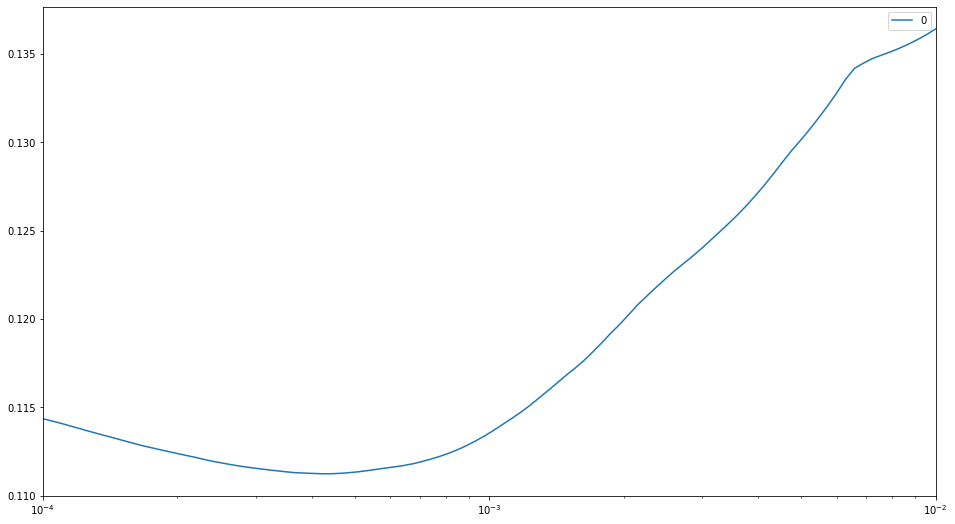

In [499]:
#Tune the lambda(alpha)
matplotlib.rcParams['figure.figsize'] = (16, 9)
test_error_mean=[]
parameter = {}
alphas_lasso = np.logspace(-4, -2, 100)

for i in alphas_lasso:
    lasso = Lasso(alpha = i)
    kf = KFold(5, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse = np.sqrt(-cross_val_score(lasso, train.values, h_price['LogPrice'], scoring="neg_mean_squared_error", cv = kf))
    test_error_mean.append(np.mean(rmse))
    parameter[test_error_mean[-1]] = i

df_test_mean = pd.DataFrame(test_error_mean, index=alphas_lasso)
df_test_mean.plot(logx=True)
alpha_opt = parameter[min(parameter)]
print("Error:",min(parameter))
print("lambda:", alpha_opt)

### Feature Selection via Lasso 

<Figure size 1152x648 with 0 Axes>

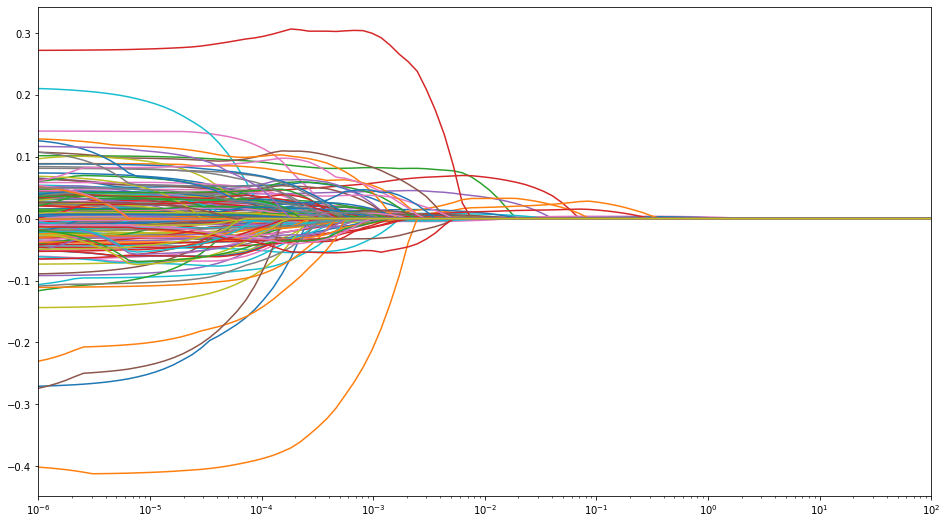

In [500]:
# plot the coef vs alpha
matplotlib.rcParams['figure.figsize'] = (16, 9)
plt.figure(figsize= (16,9))
alphas_lasso = np.logspace(-6, 2, 100)
coef_lasso = []
for i in alphas_lasso:
    lasso.set_params(alpha=i).fit(train, h_price['LogPrice'])
    coef_lasso.append(lasso.coef_)
df_coef = pd.DataFrame(coef_lasso, index=alphas_lasso, columns = train.columns)
df_coef.plot(logx=True, legend = False)
plt.show()

In [502]:
# Try to find orders of coeffs which reach to 0
parameter = {}
Columns = []
Lasso_coef = []
#plt.figure(figsize= (16,9))
alphas_lasso = np.logspace(-6, 2, 100)
for i in alphas_lasso:
    for j in range(5):
        coef_lasso = []
        test_error = []
        x_train, x_test, y_train, y_test = ms.train_test_split(train, h_price['LogPrice'], 
                                                       test_size=1.0/5, random_state=j)
        lasso.set_params(alpha=i).fit(x_train, y_train)
        Lasso_coef.append(lasso.coef_)
        COEF = pd.DataFrame(Lasso_coef, columns =x_train.columns)

COEF =COEF.groupby(np.arange(len(COEF.index))//5).mean()
zero_feature =[]
zero_dict = {}
for i in range(100):
    new_feature = []
    df = COEF.loc[[i],]
    zero_feature.append(df.loc[:,(df == 0).any()].columns)
    if i>0:
        for feature in zero_feature[i]:
            if (feature in zero_feature[i-1]) == False:
                new_feature.append(feature)
        if new_feature != []:
            zero_dict[i]=new_feature
            print(new_feature)
            print('lambda =:', alphas_lasso[i])
            print('*'*100)

['LandSlope_Gtl']
lambda =: 1.747528400007683e-06
****************************************************************************************************
['Exterior1st_AsphShn']
lambda =: 2.8480358684358048e-05
****************************************************************************************************
['HouseStyle_SLvl', 'RoofStyle_Shed', 'Exterior1st_CBlock', 'Exterior2nd_CBlock']
lambda =: 4.1320124001153344e-05
****************************************************************************************************
['Exterior2nd_Brk Cmn']
lambda =: 4.977023564332114e-05
****************************************************************************************************
['Condition1_RRNe', 'RoofStyle_Mansard', 'Exterior1st_Stone', 'SaleType_Con']
lambda =: 5.994842503189409e-05
****************************************************************************************************
['LotShape_IR3', 'Exterior2nd_Stone', 'Electrical_Mix']
lambda =: 7.220809018385471e-05
*******************

['MasVnrArea', 'PavedDrive', 'EnclosedPorch', 'MoSold']
lambda =: 0.010974987654930568
****************************************************************************************************
['BsmtFinType1', 'YrSold']
lambda =: 0.01592282793341094
****************************************************************************************************
['LotArea', 'BsmtFinSF2']
lambda =: 0.019179102616724886
****************************************************************************************************
['GarageFinish', 'ScreenPorch']
lambda =: 0.023101297000831626
****************************************************************************************************
['KitchenQual']
lambda =: 0.02782559402207126
****************************************************************************************************
['OpenPorchSF']
lambda =: 0.03351602650938848
****************************************************************************************************
['WoodDeckSF']
lambda =: 0.04037017258

In [504]:
n_zero_order = np.where(alphas_lasso == 0.0004641588833612782)[0][0]
train_2nd = train.copy()
train_2nd.drop(list(zero_feature[n_zero_order]),axis = 1, inplace = True)

Score Min: 0.11083490105386207
opyimized lambda: 0.00023644894126454073


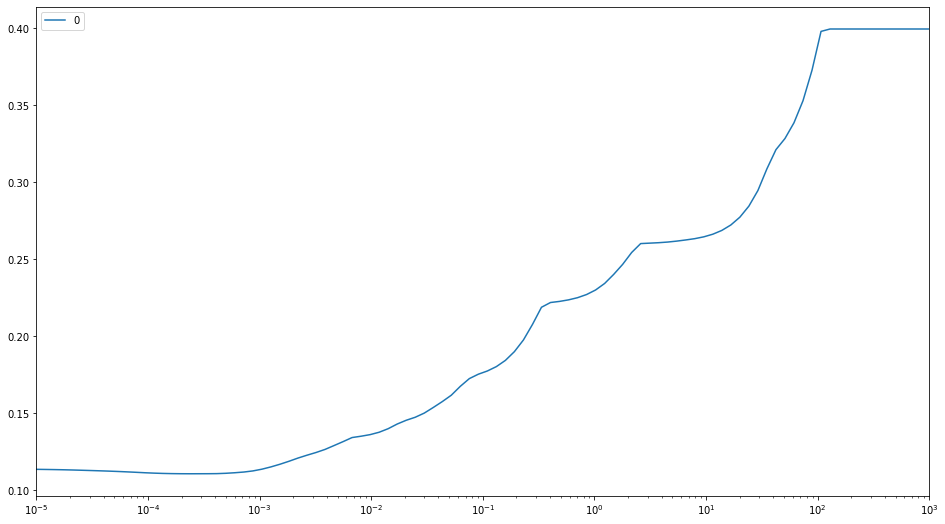

In [505]:
#tune the lambda for updated training dataset(alpha)
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (16, 9)
test_error_mean=[]
parameter = {}
alphas_lasso = np.logspace(-5, 3, 100)
for i in alphas_lasso:
    lasso = Lasso(alpha = i)
    kf = KFold(5, shuffle=True, random_state=42).get_n_splits(train_2nd.values)
    rmse = np.sqrt(-cross_val_score(lasso, train_2nd.values, h_price['LogPrice'], scoring="neg_mean_squared_error", cv = kf))
    test_error_mean.append(np.mean(rmse))
    parameter[test_error_mean[-1]] = i

df_test_mean = pd.DataFrame(test_error_mean, index=alphas_lasso)
df_test_mean.plot(logx=True)
lasso_alpha_opt = parameter[min(parameter)]
print("Score Min:",min(parameter))
print("opyimized lambda:", lasso_alpha_opt)


In [506]:
lasso = Lasso(alpha = lasso_alpha_opt)

kf_ori = KFold(5, shuffle=True, random_state=42).get_n_splits(train.values)
rmse_ori= np.sqrt(-cross_val_score(lasso, train.values, h_price['LogPrice'], scoring="neg_mean_squared_error", cv = kf))
kf_new = KFold(5, shuffle=True, random_state=42).get_n_splits(train_2nd.values)
rmse_new= np.sqrt(-cross_val_score(lasso, train_2nd.values, h_price['LogPrice'], scoring="neg_mean_squared_error", cv = kf))
lasso_scores_train = ms.cross_val_score(lasso, train.values, h_price['LogPrice'] ,cv=5)
lasso_scores = ms.cross_val_score(lasso, train_2nd.values, h_price['LogPrice'] ,cv=5)
print("R2 before Dropping is:", round(np.mean(ridge_scores_train),4),"/","RMSE before Dropping:",round(np.mean(rmse_ori),5))
print("R2 std before Dropping is:", round(np.std(ridge_scores_train),4),"/","RMSE Std before Dropping:",round(np.std(rmse_ori),5))
print('-'*75)
print("R2 after Dropping is:", round(np.mean(lasso_scores),4),"/","RMSE after Dropping:",round(np.mean(rmse_new),5))
print("R2 std after Dropping is:", round(np.std(lasso_scores),4),"/","RMSE Std after Dropping:",round(np.std(rmse_new),5))


R2 before Dropping is: 0.9186 / RMSE before Dropping: 0.11199
R2 std before Dropping is: 0.0066 / RMSE Std before Dropping: 0.00676
---------------------------------------------------------------------------
R2 after Dropping is: 0.9225 / RMSE after Dropping: 0.11083
R2 std after Dropping is: 0.0078 / RMSE Std after Dropping: 0.00676


## Model 2. Ridge

Score Min: 0.111146855712373
opyimized lambda: 3.7649358067924714


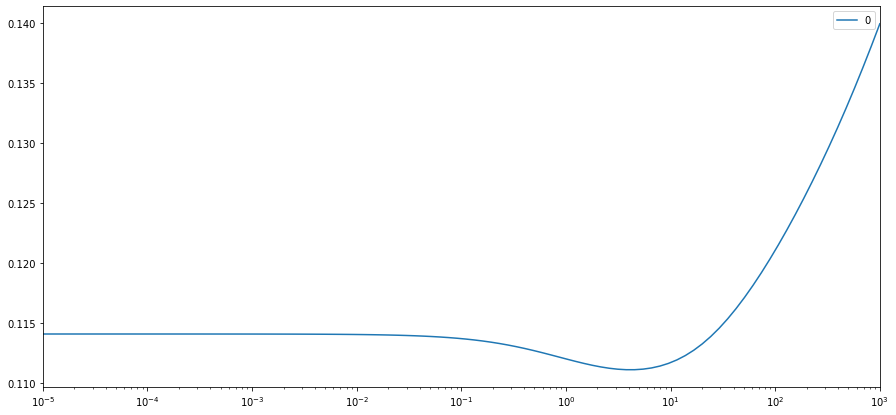

In [484]:
#tune the lambda for updated training dataset(alpha)
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (15,7)
test_error_mean=[]
parameter = {}
alphas_ridge = np.logspace(-5, 3, 100)
for i in alphas_ridge:
    ridge = Ridge(alpha = i)
    kf = KFold(5, shuffle=True, random_state=42).get_n_splits(train_2nd.values)
    rmse = np.sqrt(-cross_val_score(ridge, train_2nd.values, h_price['LogPrice'], scoring="neg_mean_squared_error", cv = kf))
    test_error_mean.append(np.mean(rmse))
    parameter[test_error_mean[-1]] = i

df_test_mean = pd.DataFrame(test_error_mean, index=alphas_lasso)
df_test_mean.plot(logx=True)
ridge_alpha_opt = parameter[min(parameter)]
print("Score Min:",min(parameter))
print("opyimized lambda:", ridge_alpha_opt)

In [485]:
ridge = Ridge(ridge_alpha_opt) # create a ridge regression instance

kf_ori = KFold(6, shuffle=True, random_state=42).get_n_splits(train.values)
rmse_ori= np.sqrt(-cross_val_score(ridge, train.values, h_price['LogPrice'], scoring="neg_mean_squared_error", cv = kf))
kf_new = KFold(6, shuffle=True, random_state=42).get_n_splits(train_2nd.values)
rmse_new= np.sqrt(-cross_val_score(ridge, train_2nd.values, h_price['LogPrice'], scoring="neg_mean_squared_error", cv = kf))
ridge_scores_train = ms.cross_val_score(ridge, train.values, h_price['LogPrice'] ,cv=5)
ridge_scores = ms.cross_val_score(ridge, train_2nd.values, h_price['LogPrice'] ,cv=5)
print("R2 before Dropping is:", round(np.mean(ridge_scores_train),4),"/","RMSE before Dropping:",round(np.mean(rmse_ori),6))
print("R2 std before Dropping is:", round(np.std(ridge_scores_train),4),"/","RMSE Std before Dropping:",round(np.std(rmse_ori),6))
print('-'*75)
print("R2 after Dropping is:", round(np.mean(ridge_scores),4),"/","RMSE after Dropping:",round(np.mean(rmse_new),6))
print("R2 std after Dropping is:", round(np.std(ridge_scores),4),"/","RMSE Std after Dropping:",round(np.std(rmse_new),6))

R2 before Dropping is: 0.9186 / RMSE before Dropping: 0.113689
R2 std before Dropping is: 0.0066 / RMSE Std before Dropping: 0.006419
---------------------------------------------------------------------------
R2 after Dropping is: 0.9222 / RMSE after Dropping: 0.111147
R2 std after Dropping is: 0.0069 / RMSE Std after Dropping: 0.006536


## Model 3. Elastic Regression

In [488]:
#Elastic regression tune alpha
para_2nd = {}
alphas_elastic = np.logspace(-4, 2, 100)
for j in alphas_elastic:
    elastic = ElasticNet(alpha = j, l1_ratio = 0.8, random_state=5)
    kf = KFold(5, shuffle=True, random_state=26).get_n_splits(train_2nd.values)
    rmse= np.sqrt(-cross_val_score(elastic, train_2nd.values, h_price['LogPrice'], scoring="neg_mean_squared_error", cv = kf))
    para_2nd[np.mean(rmse)] = j
alpha_opt_2nd = para_2nd[min(para_2nd)]
print("The Optimized Alpha is:", alpha_opt_2nd)

The Optimized Alpha is: 0.0003053855508833416


In [489]:
#Elastic regression tune rho
para_2nd = {}
for j in np.arange(0,1.0,0.02):
    elastic = ElasticNet(alpha = alpha_opt_2nd, l1_ratio = j,random_state=5)
    kf = KFold(5, shuffle=True, random_state=26).get_n_splits(train_2nd.values)
    rmse= np.sqrt(-cross_val_score(elastic, train_2nd.values, h_price['LogPrice'], scoring="neg_mean_squared_error", cv = kf))
    para_2nd[np.mean(rmse)] = j
rho_opt_2nd = para_2nd[min(para_2nd)]
print("The Optimized Rho is:", rho_opt_2nd)

The Optimized Rho is: 0.8


In [490]:
elastic = ElasticNet(alpha = alpha_opt_2nd, l1_ratio = rho_opt_2nd) # create a ridge regression instance

kf_ori = KFold(5, shuffle=True, random_state=42).get_n_splits(train.values)
rmse_ori= np.sqrt(-cross_val_score(elastic, train.values, h_price['LogPrice'], scoring="neg_mean_squared_error", cv = kf))
kf_new = KFold(5, shuffle=True, random_state=42).get_n_splits(train_2nd.values)
rmse_new= np.sqrt(-cross_val_score(elastic, train_2nd.values, h_price['LogPrice'], scoring="neg_mean_squared_error", cv = kf))
elas_scores_train = ms.cross_val_score(elastic, train.values, h_price['LogPrice'] ,cv=5)
elas_scores = ms.cross_val_score(elastic, train_2nd.values, h_price['LogPrice'] ,cv=5)
print("R2 before Dropping is:", round(np.mean(elas_scores_train),4),"/","RMSE before Dropping:",round(np.mean(rmse_ori),6))
print("R2 std before Dropping is:", round(np.std(elas_scores_train),4),"/","RMSE Std before Dropping:",round(np.std(rmse_ori),6))
print('-'*75)
print("R2 after Dropping is:", round(np.mean(elas_scores),4),"/","RMSE after Dropping:",round(np.mean(rmse_new),6))
print("R2 std after Dropping is:", round(np.std(elas_scores),4),"/","RMSE Std after Dropping:",round(np.std(rmse_new),6))

R2 before Dropping is: 0.9211 / RMSE before Dropping: 0.111886
R2 std before Dropping is: 0.0079 / RMSE Std before Dropping: 0.006757
---------------------------------------------------------------------------
R2 after Dropping is: 0.9226 / RMSE after Dropping: 0.110809
R2 std after Dropping is: 0.0078 / RMSE Std after Dropping: 0.006726
